In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_median
import numpyro_glm.ordinal.models as glm_ordinal
import numpyro_glm.ordinal.plots as ordinal_plots
import pandas as pd
import seaborn as sns

numpyro.set_host_device_count(4)

# Exercise 23.2
## (A) Thresholded cummulative-normal model with random guessing mixture

In [3]:
rating_cat = pd.CategoricalDtype([1, 2, 3, 4, 5, 6, 7], ordered=True)
movies_df: pd.DataFrame = pd.read_csv('datasets/Movies.csv')
movies_df['Rating'] = (movies_df['Rating']
                       .map({1: 1,
                             1.5: 2,
                             2: 3,
                             2.5: 4,
                             3: 5,
                             3.5: 6,
                             4: 7})
                       .astype(rating_cat))
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Title        100 non-null    object  
 1   Year         100 non-null    int64   
 2   Length       100 non-null    int64   
 3   Cast         100 non-null    int64   
 4   Rating       100 non-null    category
 5   Description  100 non-null    int64   
dtypes: category(1), int64(4), object(1)
memory usage: 4.5+ KB


In [4]:
kernel = NUTS(glm_ordinal.yord_metric_predictors_robust_guessing,
              init_strategy=init_to_median,
              target_accept_prob=.95)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(movies_df['Rating'].cat.codes.values),
    x=jnp.array(movies_df[['Year', 'Length']].values),
    K=rating_cat.categories.size,
)
mcmc.print_summary()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     _a[0]     -0.60      0.18     -0.59     -0.88     -0.30  23419.68      1.00
     _a[1]      0.90      0.21      0.89      0.56      1.23  20151.61      1.00
       _a0      3.23      0.31      3.24      2.72      3.75  13510.14      1.00
     alpha      0.16      0.08      0.16      0.03      0.28  27742.81      1.00
     sigma      0.92      0.19      0.92      0.60      1.23  18422.16      1.00
   thres_2      2.28      0.23      2.27      1.91      2.63  19110.99      1.00
   thres_3      3.02      0.31      3.02      2.51      3.51  14448.30      1.00
   thres_4      3.94      0.42      3.96      3.24      4.63  13128.94      1.00
   thres_5      6.41      1.34      6.03      4.56      8.66  16832.48      1.00

Number of divergences: 2


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


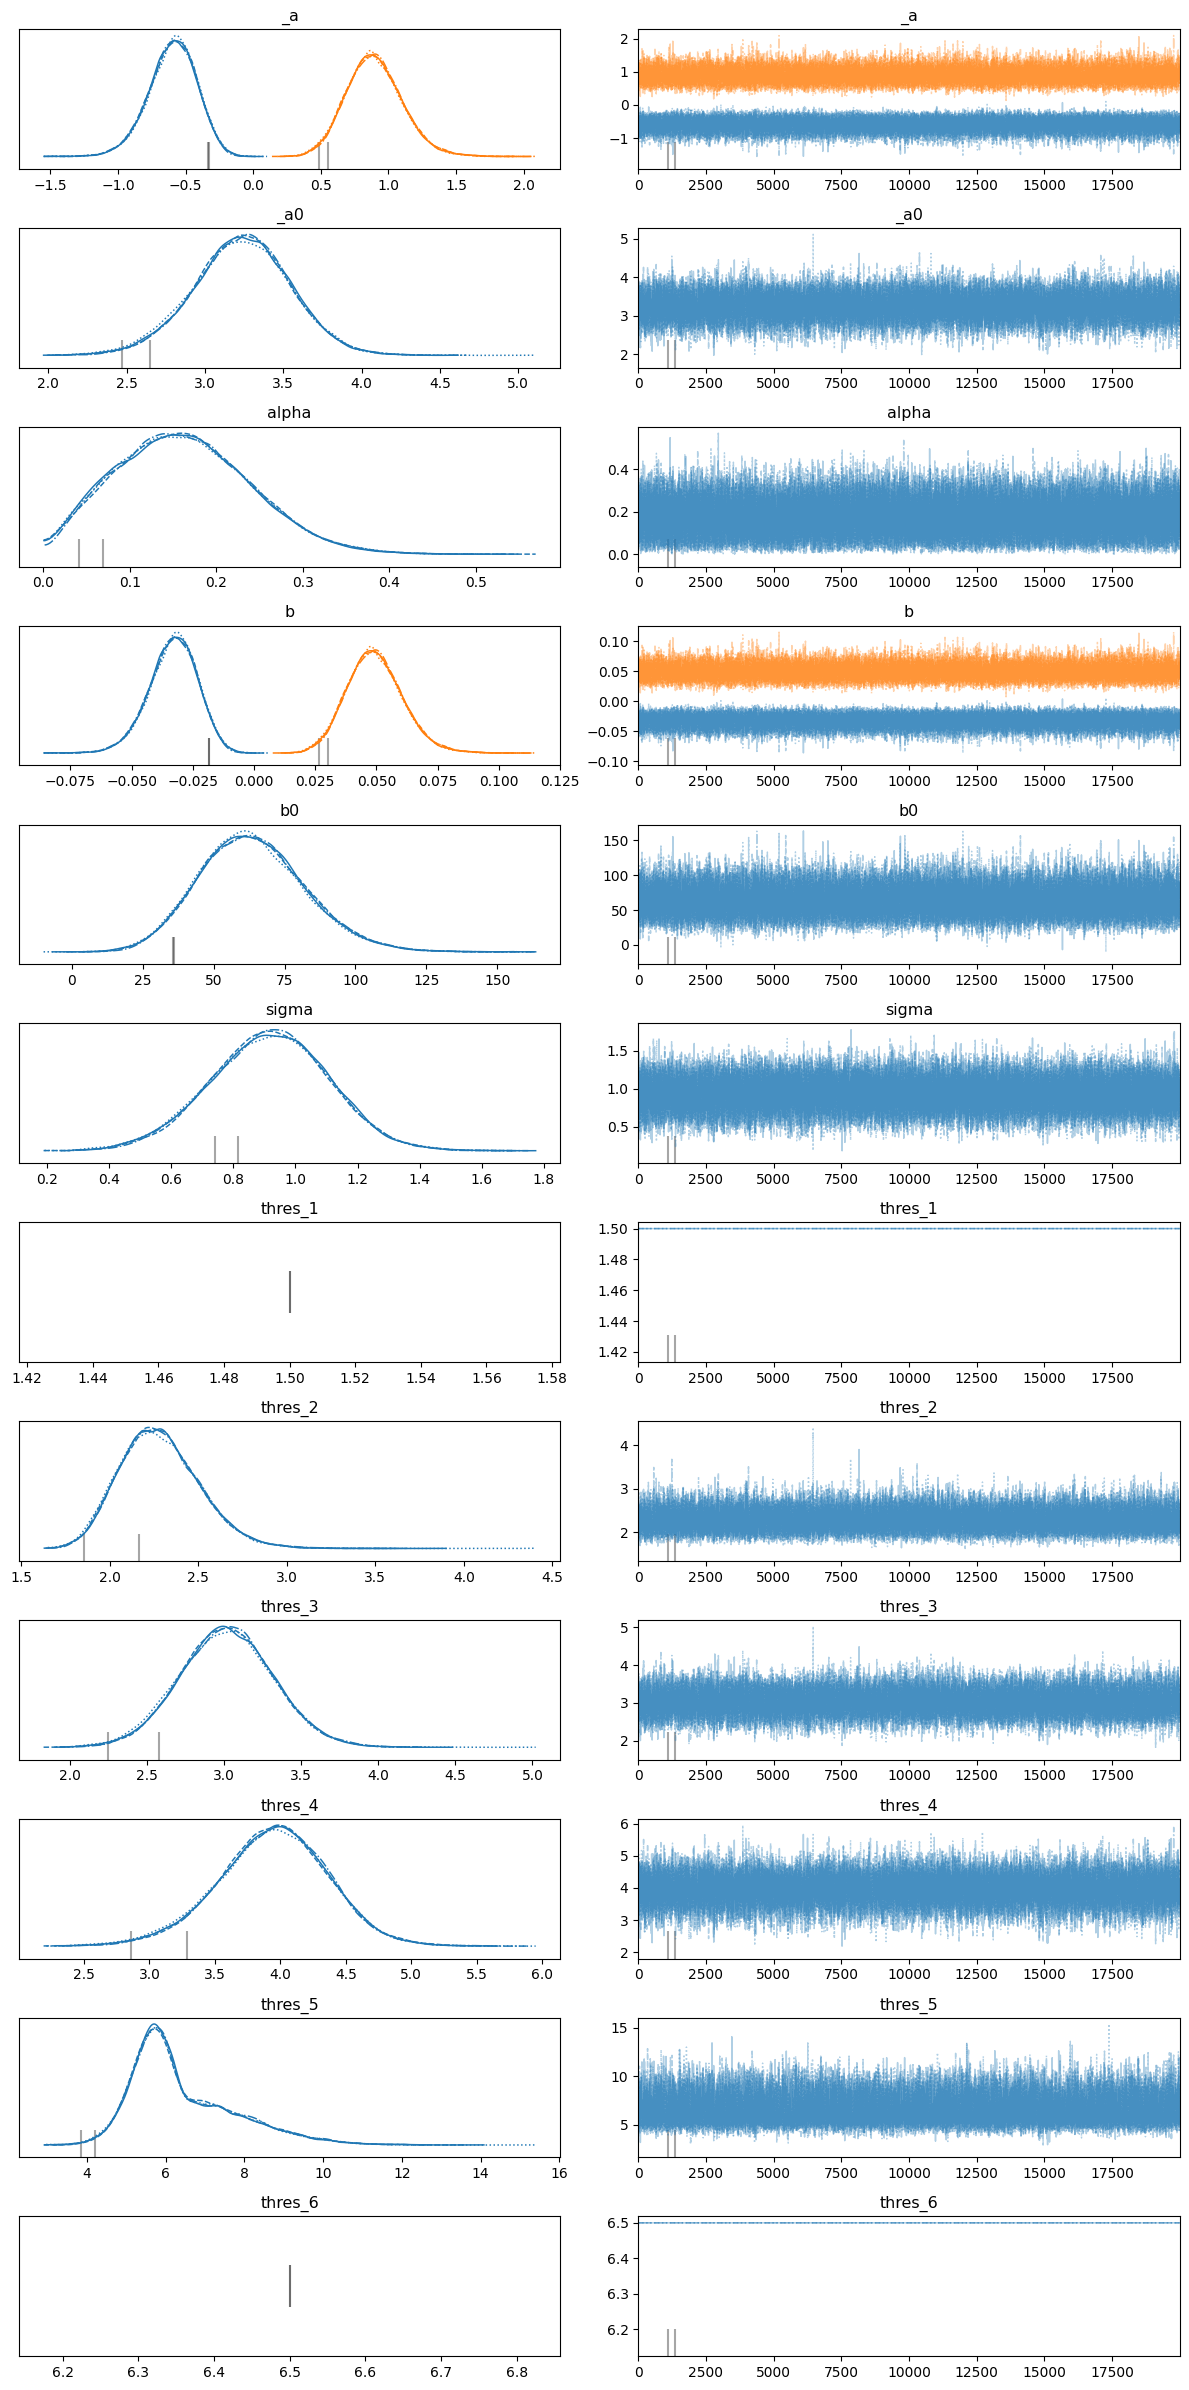

In [5]:
idata_movies = az.from_numpyro(
    mcmc,
    coords=dict(pred=['Year', 'Length']),
    dims=dict(b=['pred'])
)
az.plot_trace(idata_movies, '~mu')
plt.tight_layout()

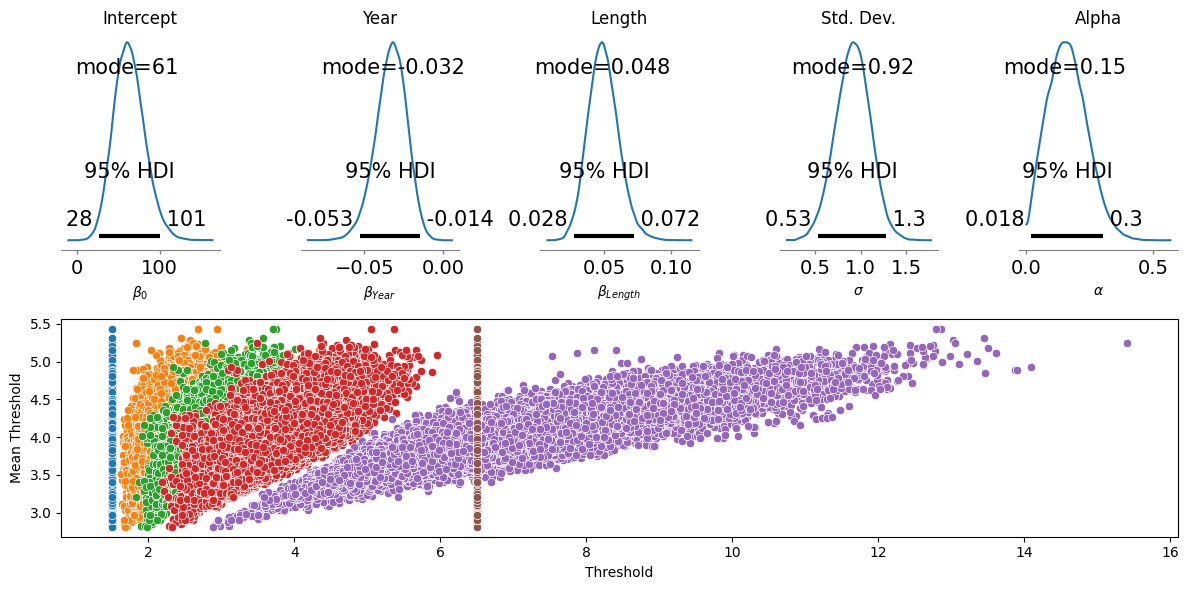

In [6]:
fig: plt.Figure = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=2, ncols=5)

# Plot intercept posterior distribution.
ax: plt.Axes = fig.add_subplot(gs[0, 0])
az.plot_posterior(
    idata_movies, 'b0', hdi_prob=.95, point_estimate='mode', ax=ax)
ax.set_title('Intercept')
ax.set_xlabel('$\\beta_0$')

# Plot coefficient for year.
ax: plt.Axes = fig.add_subplot(gs[0, 1])
az.plot_posterior(
    idata_movies,
    'b', coords=dict(pred='Year'),
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Year')
ax.set_xlabel('$\\beta_{Year}$')

# Plot coefficient for length.
ax: plt.Axes = fig.add_subplot(gs[0, 2])
az.plot_posterior(
    idata_movies,
    'b', coords=dict(pred='Length'),
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Length')
ax.set_xlabel('$\\beta_{Length}$')

# Plot standard deviation.
ax: plt.Axes = fig.add_subplot(gs[0, 3])
az.plot_posterior(
    idata_movies,
    'sigma',
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Std. Dev.')
ax.set_xlabel('$\\sigma$')

# Plot alpha.
ax: plt.Axes = fig.add_subplot(gs[0, 4])
az.plot_posterior(
    idata_movies,
    'alpha',
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Alpha')
ax.set_xlabel('$\\alpha$')

# Plot thresholds scatter.
ax: plt.Axes = fig.add_subplot(gs[1, :])
ordinal_plots.plot_threshold_scatter(
    idata_movies,
    ['thres_1', 'thres_2', 'thres_3', 'thres_4', 'thres_5', 'thres_6'],
    ax=ax,
)
ax.set_xlabel('Threshold')
ax.set_ylabel('Mean Threshold')

fig.tight_layout()

__Is there anything unusual about the posterior distribution on the thresholds, and why?__
Some sampled values of the thresholds are inverted
(smaller thresholds have values larger than larger thresholds,
for instance, the last two thresholds in the figure above).
This is because when those values are sampled,
in this model,
the probability of a category will still be larger than zero because of the guessing distribution.
However, for the normal model (without the guessing parameter),
those values are not valid and not shown in the resulting chains.

## (B) Thresholded cummulative-$t$-distribution model

In [7]:
# WIP: in order for this model to work,
# `betainc` function of jax has to have gradient w.r.t to its parameters
# (https://github.com/pyro-ppl/numpyro/issues/1452).
# kernel = NUTS(glm_ordinal.yord_metric_predictors_robust_t_dist,
#               init_strategy=init_to_median,
#               target_accept_prob=.90)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)
# mcmc.run(
#     random.PRNGKey(0),
#     y=jnp.array(movies_df['Rating'].cat.codes.values),
#     x=jnp.array(movies_df[['Year', 'Length']].values),
#     K=rating_cat.categories.size,
# )
# mcmc.print_summary()

In [8]:
# idata_t_dist = az.from_numpyro(
#     mcmc,
#     coords=dict(pred=['Year', 'Length']),
#     dims=dict(b=['pred'])
# )
# az.plot_trace(idata_t_dist, '~mu')
# plt.tight_layout()